In [1]:
from glob import glob
subtitles_paths = sorted(glob('subtitles/*.ass'))

In [2]:
subtitles_paths[:5]

['subtitles/Naruto Season 1 - 01.ass',
 'subtitles/Naruto Season 1 - 02.ass',
 'subtitles/Naruto Season 1 - 03.ass',
 'subtitles/Naruto Season 1 - 04.ass',
 'subtitles/Naruto Season 1 - 05.ass']

In [4]:
scripts = []
episode_num = []
for path in subtitles_paths:
    with open(path, 'r') as file:
        lines = file.readlines()
        lines = lines[27:] # skip first 27 rows

        rows = [",".join(line.split(',')[9:]) for line in lines]  # drop first 9 columns, 10th column == text
    
    rows = [line.replace('\\N', ' ') for line in rows]  # replace \n with space to clean text
    script = " ".join(rows) # merge all string together

    episode = int(path.split('-')[1].split('.')[0].strip()) # extract episode number from file path

    scripts.append(script)
    episode_num.append(episode)     

In [5]:
import pandas as pd

df = pd.DataFrame.from_dict({'episode':episode_num, 'script':scripts})

In [6]:
df.head()

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


## extract name entities

In [3]:
import spacy
nlp = spacy.load("en_core_web_trf")

/Users/askn/opt/anaconda3/envs/naruto/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/askn/opt/anaconda3/envs/naruto/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/askn/opt/anaconda3/envs/naruto/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [7]:
doc = nlp("Mark went to Germany")

for ent in doc.ents:
    print(ent.text, ent.label_)

Mark PERSON
Germany GPE


- Call NLP function on a sentence to extract name entity

In [8]:
from nltk import sent_tokenize

def get_ners(script):
    script_sentences = sent_tokenize(script) # divide doc into list of sentences

    ner_output = []

    for sentence in script_sentences:
        doc = nlp(sentence)
        ners = set()
        for ent in doc.ents:
            if ent.label_ == 'PERSON':
                full_name = ent.text
                first_name = full_name.split(' ')[0]
                ners.add(first_name)
        ner_output.append(list(ners))
    return ner_output



In [13]:
df['ners'] = df['script'].apply(get_ners)

- 2 characters appear in 10 sentences window

In [14]:
window = 10
entity_relationship = []

for row in df['ners']:
    previous_entities_in_window = []

    for sentence in row:
        previous_entities_in_window.append(sentence)
        previous_entities_in_window = previous_entities_in_window[-10:]

        previous_entities_flattened = sum(previous_entities_in_window, [])

        for entity in sentence:
            for entity_in_window in previous_entities_flattened:
                if entity != entity_in_window:
                    # avoid duplicate information and easier to analyze
                    entity_rel = sorted([entity, entity_in_window])  # N,S or S,N will always be represented as N,S
                    entity_relationship.append(entity_rel)

In [15]:
relationship_df = pd.DataFrame({'value':entity_relationship})

In [16]:
relationship_df['source'] = relationship_df['value'].apply(lambda x: x[0])
relationship_df['target'] = relationship_df['value'].apply(lambda x: x[1])

In [17]:
relationship_df = relationship_df.groupby(['source', 'target']).count().reset_index()

In [19]:
relationship_df = relationship_df.sort_values('value', ascending=False)
relationship_df.head()

,source,target,value
2577,Naruto,Sasuke,847
2975,Sakura,Sasuke,438
2570,Naruto,Sakura,367
1363,Hinata,Naruto,324
2809,Orochimaru,Sasuke,274


In [20]:
top_200 = relationship_df.head(200)  # top 200 character pairs

In [21]:
import networkx as nx
G = nx.from_pandas_edgelist(top_200,
                            source = 'source',
                            target = 'target',
                            edge_attr = 'value',
                            create_using = nx.Graph()
                            )

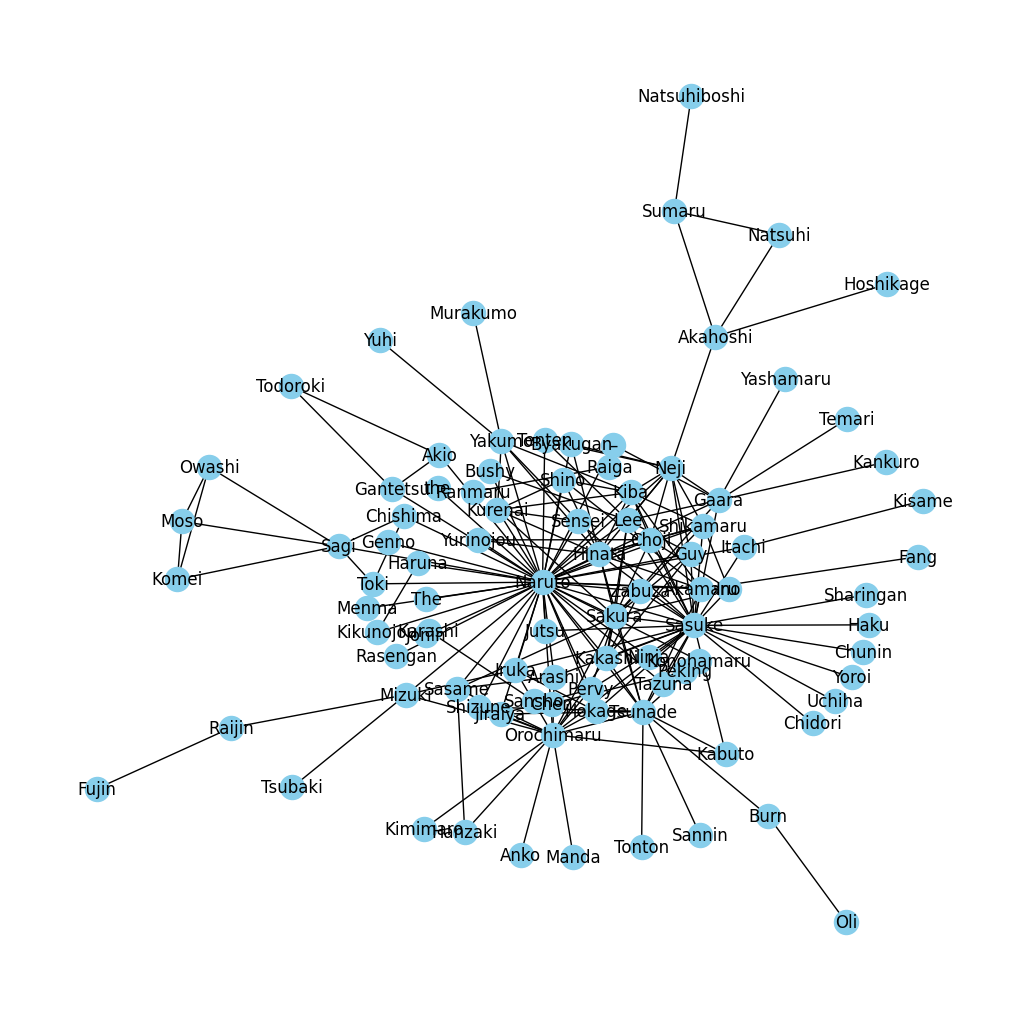

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

- hard to interpret
- use pyvis for another visualizati

In [37]:
from pyvis.network import Network
net = Network(notebook = True, width='1000px', height='700px', bgcolor='#222222', font_color='white', cdn_resources='remote')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("naruto.html")


naruto.html
